# **Lab 6: Train and fine-tune a CNN using a pre-trained model for an image classification task.**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = 96
SUBSET_SIZE = 5000
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
#load dataset
(x_all, y_all), _ = tf.keras.datasets.mnist.load_data()
x_all = x_all[:SUBSET_SIZE]
y_all = y_all[:SUBSET_SIZE]


In [ ]:
# Preprocess images
def preprocess_images(images):
    resized = [cv2.resize(img, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_AREA) for img in images]
    rgb = np.stack([np.stack([img]*3, axis=-1) for img in resized]).astype(np.uint8)
    return rgb

x_all = preprocess_images(x_all)
y_all = to_categorical(y_all, 10)

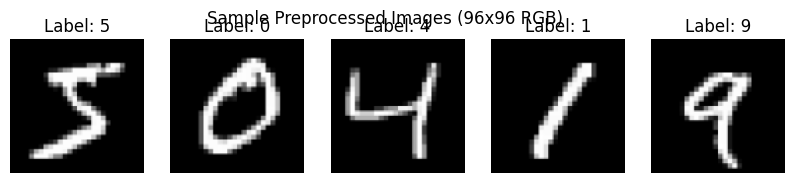

In [ ]:
# Show 5 sample preprocessed images with labels
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_all[i])
    plt.title(f"Label: {np.argmax(y_all[i])}")
    plt.axis('off')
plt.suptitle(f"Sample Preprocessed Images ({IMG_SIZE}x{IMG_SIZE} RGB)")
plt.show()

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x_all, y_all, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")


Train: (4000, 96, 96, 3), Val: (500, 96, 96, 3), Test: (500, 96, 96, 3)


In [ ]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.06),
    layers.RandomTranslation(0.06, 0.06),
    layers.RandomZoom(0.07),
])

In [ ]:
#base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

In [ ]:
#full model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=EPOCHS,batch_size=BATCH_SIZE)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.5307 - loss: 1.4903 - val_accuracy: 0.7040 - val_loss: 0.8235
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7977 - loss: 0.6261 - val_accuracy: 0.7860 - val_loss: 0.6228
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8251 - loss: 0.5204 - val_accuracy: 0.8100 - val_loss: 0.5496
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8592 - loss: 0.4168 - val_accuracy: 0.7940 - val_loss: 0.6141
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8815 - loss: 0.3579 - val_accuracy: 0.8440 - val_loss: 0.4724


In [ ]:
#Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8777 - loss: 0.4335

Test Accuracy: 0.8920


In [ ]:
#fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Keep most layers frozen
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.6936 - loss: 0.9937 - val_accuracy: 0.7980 - val_loss: 0.6351
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.8592 - loss: 0.4504 - val_accuracy: 0.8240 - val_loss: 0.5288
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8945 - loss: 0.3453 - val_accuracy: 0.8540 - val_loss: 0.4412
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9197 - loss: 0.2456 - val_accuracy: 0.8680 - val_loss: 0.3926
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9341 - loss: 0.2142 - val_accuracy: 0.8800 - val_loss: 0.3474


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8935 - loss: 0.3992

✅ Test Accuracy: 0.9040


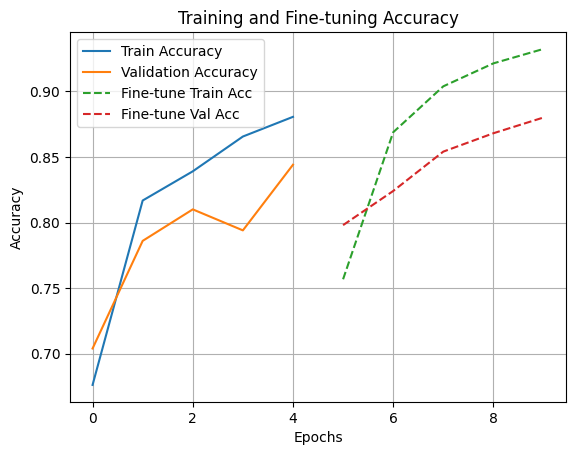

In [ ]:
#ploting model accuracry
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(range(EPOCHS, EPOCHS+EPOCHS),
         fine_tune_history.history['accuracy'], label='Fine-tune Train Acc', linestyle='--')
plt.plot(range(EPOCHS, EPOCHS+EPOCHS),
         fine_tune_history.history['val_accuracy'], label='Fine-tune Val Acc', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Fine-tuning Accuracy")
plt.legend()
plt.grid(True)
plt.show()
